# Safety Stock and Reorder Point Analysis - Solution

You're a supply chain analyst at TechParts Inc. Your task is to determine appropriate safety stock levels and reorder points for various components to maintain desired service levels while minimizing inventory costs.

This analysis will help you:
- Calculate safety stock based on demand and lead time variability
- Determine reorder points that balance stockout risk with holding costs
- Analyze the impact of service level decisions on inventory investment

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

## Part 1: Basic Safety Stock Calculation

Calculate safety stock for a product with the following parameters:
- Average daily demand = 100 units
- Standard deviation of daily demand = 20 units
- Average lead time = 5 days
- Standard deviation of lead time = 1 day
- Desired service level = 95%

In [2]:
# Define parameters
daily_demand = 100  # Average daily demand
demand_stddev = 20  # Standard deviation of daily demand
lead_time = 5      # Average lead time in days
lead_time_stddev = 1  # Standard deviation of lead time
service_level = 0.95  # Desired service level

# Calculate safety factor (z-score)
z_score = stats.norm.ppf(service_level)

# Calculate standard deviation during lead time
# Formula: sqrt(L * σ_d² + D² * σ_L²)
lead_time_demand_stddev = np.sqrt(
    lead_time * demand_stddev**2 + 
    daily_demand**2 * lead_time_stddev**2
)

# Calculate safety stock
safety_stock = z_score * lead_time_demand_stddev

# Calculate reorder point
reorder_point = daily_demand * lead_time + safety_stock

print(f'Safety Stock: {safety_stock:.1f} units')
print(f'Reorder Point: {reorder_point:.1f} units')
print(f'Average Inventory: {(safety_stock + daily_demand * lead_time/2):.1f} units')

Safety Stock: 180.2 units
Reorder Point: 680.2 units
Average Inventory: 430.2 units


## Part 2: Service Level Analysis

Analyze how different service levels affect safety stock requirements and total inventory costs.

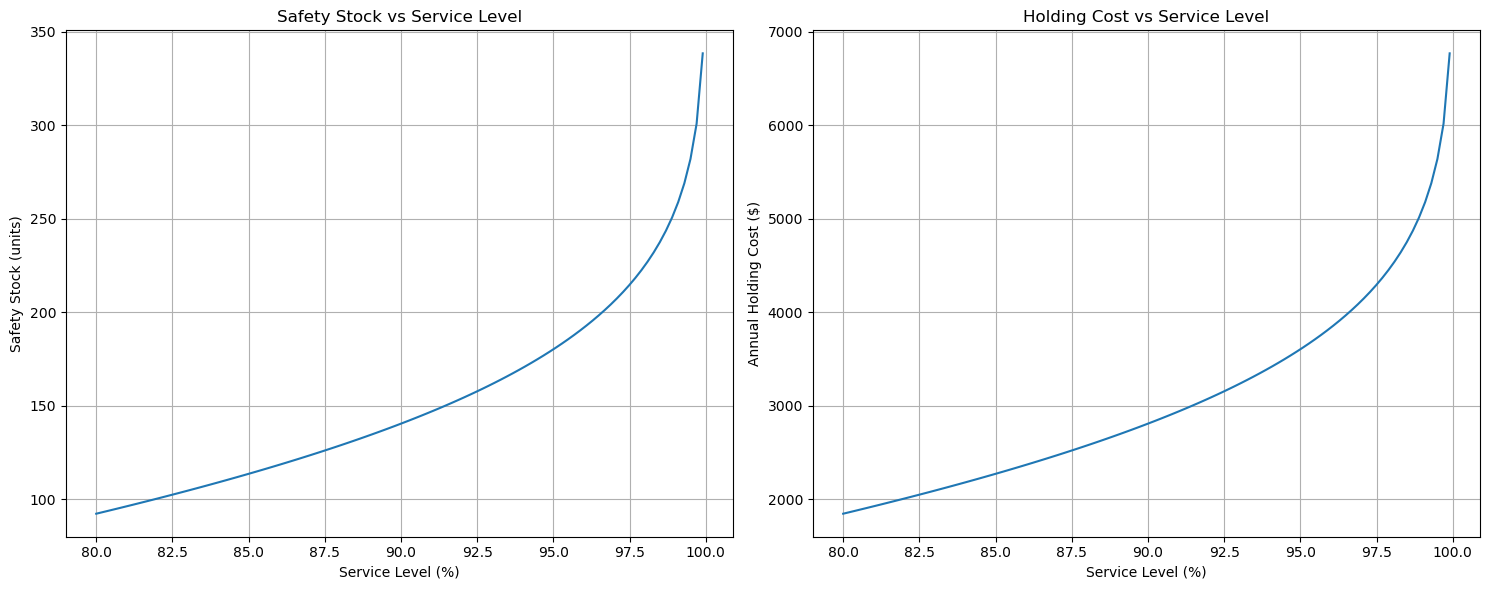

Safety stock increase (95% to 99%): 78.0 units
Additional annual holding cost: $1559.29


In [3]:
# Create range of service levels
service_levels = np.linspace(0.8, 0.999, 100)
z_scores = stats.norm.ppf(service_levels)

# Calculate safety stock for each service level
safety_stocks = z_scores * lead_time_demand_stddev

# Assume holding cost is $20 per unit per year
holding_cost = 20
annual_holding_costs = safety_stocks * holding_cost

# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Safety Stock vs Service Level
ax1.plot(service_levels * 100, safety_stocks)
ax1.set_xlabel('Service Level (%)')
ax1.set_ylabel('Safety Stock (units)')
ax1.set_title('Safety Stock vs Service Level')
ax1.grid(True)

# Holding Cost vs Service Level
ax2.plot(service_levels * 100, annual_holding_costs)
ax2.set_xlabel('Service Level (%)')
ax2.set_ylabel('Annual Holding Cost ($)')
ax2.set_title('Holding Cost vs Service Level')
ax2.grid(True)

plt.tight_layout()
plt.show()

# Calculate specific comparisons
idx_95 = np.abs(service_levels - 0.95).argmin()
idx_99 = np.abs(service_levels - 0.99).argmin()

ss_increase = (safety_stocks[idx_99] - safety_stocks[idx_95])
cost_increase = (annual_holding_costs[idx_99] - annual_holding_costs[idx_95])

print(f'Safety stock increase (95% to 99%): {ss_increase:.1f} units')
print(f'Additional annual holding cost: ${cost_increase:.2f}')

## Part 3: Demand and Lead Time Variability Impact

Analyze how changes in demand and lead time variability affect safety stock requirements.

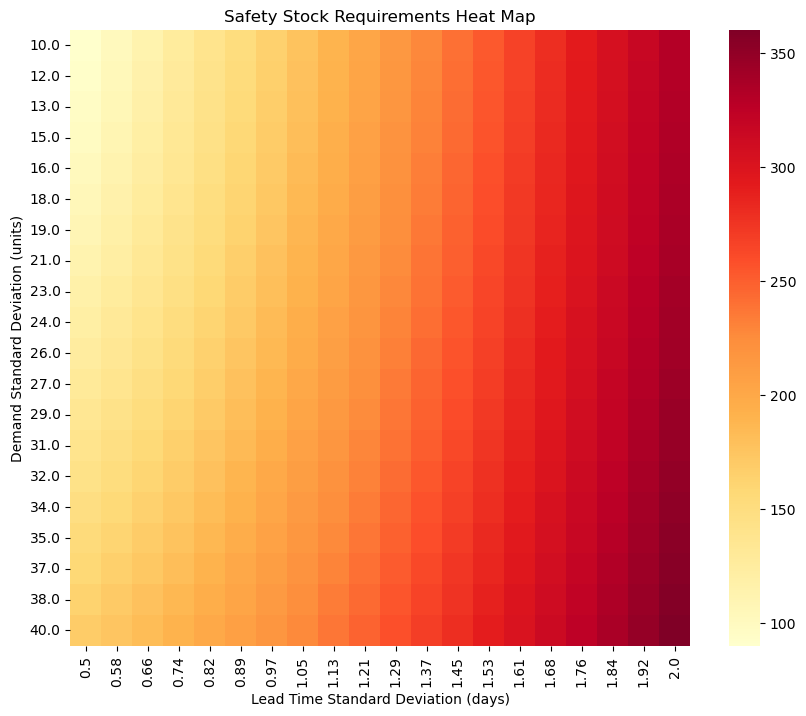

Demand variability sensitivity: 1.4 units of safety stock per unit of demand std dev
Lead time variability sensitivity: 144.6 units of safety stock per day of lead time std dev


In [4]:
# Create ranges for variability
demand_stddev_range = np.linspace(10, 40, 20)  # 10 to 40 units
lead_time_stddev_range = np.linspace(0.5, 2, 20)  # 0.5 to 2 days

# Calculate safety stock for each combination
safety_stock_matrix = np.zeros((len(demand_stddev_range), len(lead_time_stddev_range)))

for i, d_std in enumerate(demand_stddev_range):
    for j, l_std in enumerate(lead_time_stddev_range):
        lt_demand_std = np.sqrt(lead_time * d_std**2 + daily_demand**2 * l_std**2)
        safety_stock_matrix[i, j] = z_score * lt_demand_std

# Create heat map
plt.figure(figsize=(10, 8))
sns.heatmap(safety_stock_matrix,
            xticklabels=np.round(lead_time_stddev_range, 2),
            yticklabels=np.round(demand_stddev_range, 0),
            cmap='YlOrRd')
plt.xlabel('Lead Time Standard Deviation (days)')
plt.ylabel('Demand Standard Deviation (units)')
plt.title('Safety Stock Requirements Heat Map')
plt.show()

# Calculate sensitivity
base_index = len(demand_stddev_range) // 2
demand_sensitivity = (safety_stock_matrix[-1, base_index] - safety_stock_matrix[0, base_index]) / \
                    (demand_stddev_range[-1] - demand_stddev_range[0])
                    
lead_time_sensitivity = (safety_stock_matrix[base_index, -1] - safety_stock_matrix[base_index, 0]) / \
                       (lead_time_stddev_range[-1] - lead_time_stddev_range[0])

print(f'Demand variability sensitivity: {demand_sensitivity:.1f} units of safety stock per unit of demand std dev')
print(f'Lead time variability sensitivity: {lead_time_sensitivity:.1f} units of safety stock per day of lead time std dev')

## Part 4: Multiple Products Analysis

Calculate safety stock and reorder points for multiple products with different characteristics.

Product Analysis Summary:
  Product_ID  Safety_Stock  Reorder_Point  Inventory_Investment
0       P001        442.21        1253.27              43176.20
1       P002        354.99        2295.02              10986.67
2       P003       1300.12        4307.50              23603.19
3       P004        696.64        1783.00              45737.60
4       P005        345.79        1602.22              15360.66


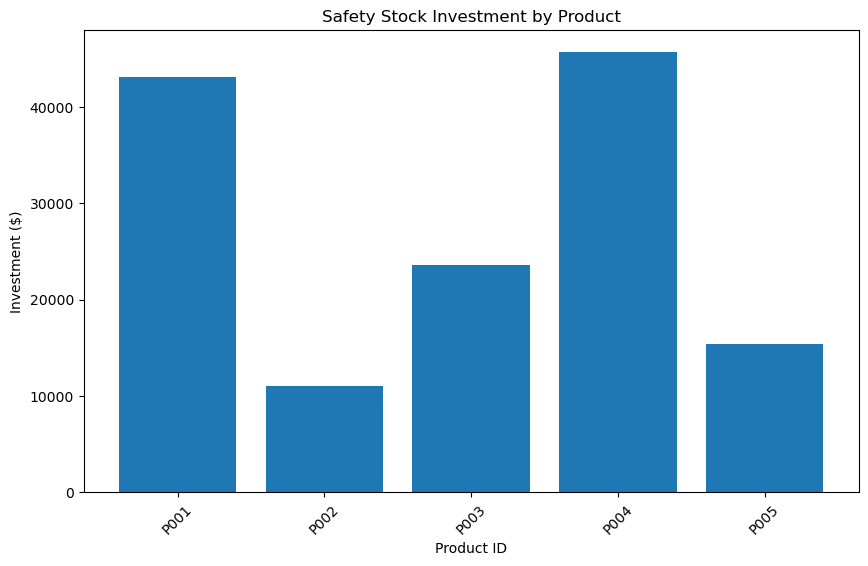


Summary Statistics:
       Safety_Stock  Reorder_Point  Inventory_Investment
count          5.00           5.00                  5.00
mean         627.95        2248.20              27772.87
std          401.61        1211.04              15915.56
min          345.79        1253.27              10986.67
25%          354.99        1602.22              15360.66
50%          442.21        1783.00              23603.19
75%          696.64        2295.02              43176.20
max         1300.12        4307.50              45737.60


In [5]:
# Generate sample data
np.random.seed(42)
n_products = 5

data = {
    'Product_ID': [f'P{i:03d}' for i in range(1, n_products + 1)],
    'Daily_Demand': np.random.randint(50, 500, n_products),
    'Demand_StdDev': np.random.uniform(10, 100, n_products),
    'Lead_Time': np.random.uniform(3, 10, n_products),
    'Lead_Time_StdDev': np.random.uniform(0.5, 2, n_products),
    'Service_Level': np.random.uniform(0.90, 0.99, n_products),
    'Unit_Cost': np.random.uniform(10, 100, n_products)
}

# Create DataFrame
df = pd.DataFrame(data)

# Calculate safety stock and reorder points
df['Z_Score'] = df['Service_Level'].apply(stats.norm.ppf)
df['Lead_Time_Demand_StdDev'] = np.sqrt(
    df['Lead_Time'] * df['Demand_StdDev']**2 + 
    df['Daily_Demand']**2 * df['Lead_Time_StdDev']**2
)
df['Safety_Stock'] = df['Z_Score'] * df['Lead_Time_Demand_StdDev']
df['Reorder_Point'] = df['Daily_Demand'] * df['Lead_Time'] + df['Safety_Stock']
df['Inventory_Investment'] = df['Safety_Stock'] * df['Unit_Cost']

# Display results
print("Product Analysis Summary:")
print(df[['Product_ID', 'Safety_Stock', 'Reorder_Point', 'Inventory_Investment']].round(2))

# Visualize inventory investment by product
plt.figure(figsize=(10, 6))
plt.bar(df['Product_ID'], df['Inventory_Investment'])
plt.title('Safety Stock Investment by Product')
plt.xlabel('Product ID')
plt.ylabel('Investment ($)')
plt.xticks(rotation=45)
plt.show()

# Summary statistics
print("\nSummary Statistics:")
print(df[['Safety_Stock', 'Reorder_Point', 'Inventory_Investment']].describe().round(2))